Comparei alguns modelos: logística, SVM e Random Forest. Fica mais complicado o fluxo. Fiz um pipeline legal, mas ainda falta resolver como deixar tudo otimizando usando arrays numpy e depois usar pandas. 

# Definições iniciais

## Imports

In [1146]:
# Sklearn
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV, train_test_split, StratifiedKFold,cross_val_score
from sklearn.model_selection import ParameterGrid, ParameterSampler
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

# Hyperopt
from hyperopt import fmin, hp, tpe, rand, Trials, space_eval, STATUS_OK, anneal
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
from functools import partial

# Category encoders
from category_encoders.hashing import HashingEncoder
from category_encoders.sum_coding import SumEncoder
from category_encoders.woe import WOEEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.binary import BinaryEncoder

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

# Files
from tempfile import mkdtemp
from shutil import rmtree
from joblib import Memory
import joblib
import os


## Configurando random pra deixar reprodutível

In [2]:
import random
random.seed(42)
np.random.seed(42)
random_global = 42

# Funções úteis

## Função pra submeter os resultados e salvar os arquivos necessários pra replicar

In [1144]:
class SaveModel(object):
    def __init__(self, folder_to_save, data_train=None, data_val=None, data_test=None, model=None, str_readme=None, submission_file='submission.csv'):
        self.folder_to_save = folder_to_save
        self.data_train = data_train
        self.data_val = data_val
        self.data_test = data_test
        self.model = model
        self.str_readme = str_readme
        self.submission_file = submission_file
    
    def save_model(self):
#     Create folder if not exists:
        try:
            os.makedirs(self.folder_to_save)
            print('Criando pasta %s' % self.folder_to_save)
        except Exception as e: 
            print(e)

    #     Salva os dados usados no treino
        if self.data_train is not None:
            joblib.dump(self.data_train, self.folder_to_save+'/train_data')


    #     Salva dados usados na validação
        if self.data_val is not None:
            joblib.dump(self.data_test, self.folder_to_save+'/validation_data')

    #     Salva dados usados no teste
        if self.data_test is not None:
            joblib.dump(self.data_test, self.folder_to_save+'/test_data')

    #     Salva modelo 
        if self.model is not None:
            joblib.dump(self.model, self.folder_to_save+'/model')   

    #     Arquivo README (é o que vai escrito pro commit)
        with open(self.folder_to_save+'/README.txt', "w") as text_file:
            text_file.write(self.str_readme)
            
#         Salva os predictions
        

    def commit_kaggle(self):
        predictions = self.model.predict(self.data_test)
        submission = pd.DataFrame({'PassengerId':self.data_test['passengerid'],'Survived':predictions})
        submission.to_csv(self.folder_to_save+'/'+self.submission_file,index=False)
#         print(f"kaggle competitions submit -c titanic -f submission.csv -m \"{self.str_readme}\"")
#         !! f"kaggle competitions submit -c titanic -f {self.folder_to_save+'/'+self.submission_file} -m \"{self.str_readme}\""
        if os.system(f"kaggle competitions submit -c titanic -f {self.folder_to_save+'/'+self.submission_file} -m \"{self.str_readme}\"") != 0:
            print('Erro submetendo o arquivo no kaggle!')
            
        print(f"kaggle competitions submit -c titanic -f {self.folder_to_save+'/'+self.submission_file} -m \"{self.str_readme}\"")
    
        

## Custom transformers

In [992]:
from sklearn.base import BaseEstimator, TransformerMixin

class TransformToDF(BaseEstimator, TransformerMixin):
    '''Wrapper para usar transformers do sklearn mas retorn um dataframe Pandas. Projetei para usar com transformers que não
    mudam o número de colunas na saída.'''
    
    def __init__(self, sklearn_transformer, return_df=True):
        self.sklearn_transformer = sklearn_transformer
        self.return_df = return_df
    
    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.col_names = X.columns.values.tolist()
            
        self.sklearn_transformer.fit(X, y=None)
        return self
        
    def transform(self, X, y=None):
    # assumes X is a DataFrame
        if self.return_df:
            return pd.DataFrame(self.sklearn_transformer.transform(X[self.col_names]), index=X.index, columns=self.col_names)
        else:
            return self.sklearn_transformer.transform(X)
        
class DFFeatureUnion(BaseEstimator,TransformerMixin):
    # FeatureUnion but for pandas DataFrames
    from functools import reduce

    def __init__(self, transformer_list):
        self.transformer_list = transformer_list

    def fit(self, X, y=None):
        for (name, t) in self.transformer_list:
            t.fit(X, y)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xts = [t.transform(X) for _, t in self.transformer_list]
        Xunion = reduce(lambda X1, X2: pd.merge(X1, X2, left_index=True, right_index=True), Xts)
        return Xunion
    
class ColumnExtractor(BaseEstimator,TransformerMixin):

    def __init__(self, cols, return_df=True):
        self.cols = cols
        self.return_df = return_df

    def fit(self, X, y=None):
        # stateless transformer
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        if self.return_df:
            return X[self.cols]
        else:
            return X[self.cols].values

# Carrega dados


In [707]:
df_train_val = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")
df_train_val.columns = [x.lower() for x in df_train_val.columns]
df_test.columns = [x.lower() for x in df_test.columns]

print(f'Print shape df_train_val: {df_train_val.shape}')
print(f'Print shape df_test: {df_test.shape}')


Print shape df_train_val: (891, 12)
Print shape df_test: (418, 11)


# Criação de algumas features novas

## Tamanho de família

In [708]:
full_data = [df_train_val, df_test]
for dataset in full_data:
    dataset['family_size'] = 1 + dataset['parch'] + dataset['sibsp']
    if 'survived' in dataset.columns:
        display(dataset.fillna(-999).groupby('family_size')['survived'].agg(['size', 'mean']).reset_index())
    else:
        display(dataset.fillna(-999).groupby('family_size').size())

,family_size,size,mean
0,1,537,0.303538
1,2,161,0.552795
2,3,102,0.578431
3,4,29,0.724138
4,5,15,0.200000
5,6,22,0.136364
6,7,12,0.333333
7,8,6,0.000000
8,11,7,0.000000


family_size
1     253
2      74
3      57
4      14
5       7
6       3
7       4
8       2
11      4
dtype: int64

Aparentemente depois de 4 familiares, talvez seja bom juntar depois

## Extrai o título

In [709]:
full_data = [df_train_val, df_test]
for dataset in full_data:
    dataset['title'] = dataset['name'].str.findall('([A-Z][a-z]+)\.').map(lambda x: x[0])
    if 'survived' in dataset.columns:
        display(dataset.fillna(-999).groupby('title')['survived'].agg(['size', 'mean']).reset_index().sort_values(by='mean', ascending=False))
    else:
        display(dataset.fillna(-999).groupby('title').size())
        

,title,size,mean
16,Sir,1,1.000000
2,Countess,1,1.000000
14,Ms,1,1.000000
11,Mme,1,1.000000
6,Lady,1,1.000000
10,Mlle,2,1.000000
13,Mrs,125,0.792000
9,Miss,182,0.697802
8,Master,40,0.575000
1,Col,2,0.500000


title
Col         2
Dona        1
Dr          1
Master     21
Miss       78
Mr        240
Mrs        72
Ms          1
Rev         2
dtype: int64

## Acha aspas ou parênteses no nome

In [710]:
full_data = [df_train_val, df_test]
for dataset in full_data:
    dataset['name_aspas'] = dataset['name'].str.findall('\"').map(lambda x: len(x) >= 1 ).astype('int')
    dataset['name_parenteses'] = dataset['name'].str.findall('\(').map(lambda x: len(x) >= 1 ).astype('int')
    if 'survived' in dataset.columns:
        display(dataset.fillna(-999).groupby('name_aspas')['survived'].agg(['size', 'mean']).reset_index().sort_values(by='mean', ascending=False))
        display(dataset.fillna(-999).groupby('name_parenteses')['survived'].agg(['size', 'mean']).reset_index().sort_values(by='mean', ascending=False))
    else:
        display(dataset.fillna(-999).groupby('name_aspas').size())
        display(dataset.fillna(-999).groupby('name_parenteses').size())
        

,name_aspas,size,mean
1,1,53,0.716981
0,0,838,0.362768


,name_parenteses,size,mean
1,1,143,0.769231
0,0,748,0.310160


name_aspas
0    396
1     22
dtype: int64

name_parenteses
0    340
1     78
dtype: int64

# Separa as amostras para treino e validação

In [711]:
df_train, df_val = train_test_split(df_train_val, test_size = 100, shuffle=True, stratify=df_train_val['survived'], random_state=random_global)
print(f'Print shape df_train: {df_train.shape}')
print(f'Print shape df_val: {df_val.shape}')

Print shape df_train: (791, 16)
Print shape df_val: (100, 16)


# Definição do pipeline básico a ser otimizado

In [1109]:
num_cols = ['age', 'sibsp', 'parch', 'fare', 'family_size']
cat_cols = ['sex', 'embarked', 'title', 'name_aspas', 'name_parenteses', 'pclass']

In [1110]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_global)

In [1116]:
def f_wrap_space_eval(hp_space, trial):
    """
    Utility function for more consise optimization history extraction
    
    Parameters:
    ----------------
    hp_space : hyperspace from which points are sampled
    trial : hyperopt.Trials object
    
    Returns:
    ----------------
    : dict(
        k: v
    ), where k - label of hyperparameter, v - value of hyperparameter in trial
    """
    
    return space_eval(hp_space, {k: v[0] for (k, v) in trial['misc']['vals'].items() if len(v) > 0})


def f_unpack_dict(dct):
    """
    Unpacks all sub-dictionaries in given dictionary recursively. There should be no duplicated keys 
    across all nested subdictionaries, or some instances will be lost without warning
    
    Parameters:
    ----------------
    dct : dictionary to unpack
    
    Returns:
    ----------------
    : unpacked dictionary
    """
    
    res = {}
    for (k, v) in dct.items():
        if isinstance(v, dict):
            res = {**res, **f_unpack_dict(v)}
        else:
            res[k] = v
            
    return res

In [100]:
trials_clf2 = Trials()
best_clf2 = fmin(partial(f_to_min2, X=df_train[num_cols].fillna(0), y=df_train['survived']), 
                 hp_space_clf2, algo=tpe.suggest, max_evals=500, 
                 trials=trials_clf2, rstate=np.random.RandomState(random_global))

100%|████████████████████████████████████████████████| 500/500 [10:34<00:00,  1.79s/it, best loss: -0.7784073561822904]


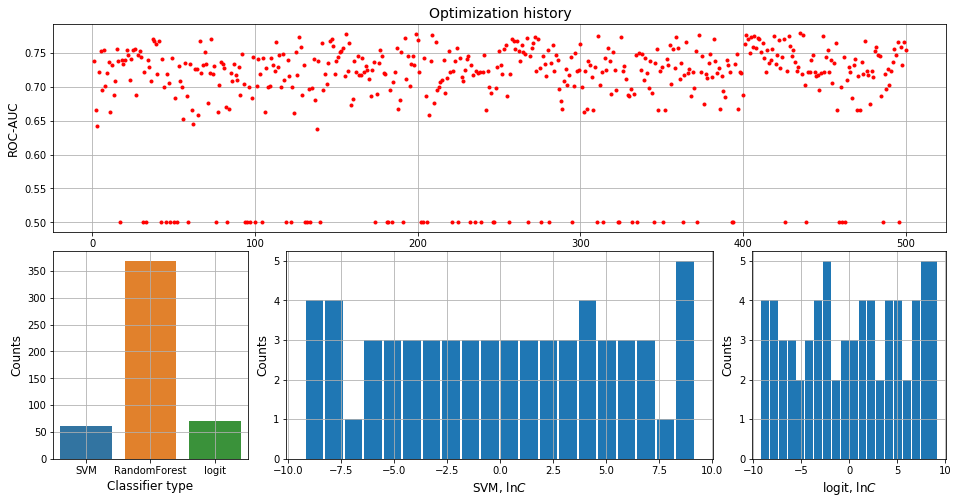

In [1115]:
fig0 = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(nrows=4, ncols=4)

# ================================
# Plotting optimization history

ax = fig0.add_subplot(gs[:2, :])
ax.plot(range(1, len(trials_clf2) + 1), [-x['result']['loss'] for x in trials_clf2], 
        color='red', marker='.', linewidth=0)

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('ROC-AUC', fontsize=12)
ax.set_title('Optimization history', fontsize=14)

ax.grid(True)

# ================================
# Plotting sampled points

samples = [f_unpack_dict(f_wrap_space_eval(hp_space_clf2, x)) for x in trials_clf2.trials]

ax = fig0.add_subplot(gs[2:, 0])
sns.countplot(x=[x['type'] for x in samples], ax=ax)

ax.set_xlabel('Classifier type', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

ax.grid(True)

# ----------------

ax = fig0.add_subplot(gs[2:, 1:3])
ax.hist(np.log([x['C'] for x in samples if x['type'] == 'SVM']), bins=20, rwidth=0.9, 
        range=(-4*np.log(10), 4*np.log(10)))

ax.set_xlabel('SVM, $\ln C$', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

ax.grid(True)

# ----------------

ax = fig0.add_subplot(gs[2:, 3])
ax.hist(np.log([x['C'] for x in samples if x['type'] == 'logit']), bins=20, rwidth=0.9, 
        range=(-4*np.log(10), 4*np.log(10)))

ax.set_xlabel('logit, $\ln C$', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

ax.grid(True)



In [1202]:
# Pipeline com Pandas dataframes em todas as etapas, o que deixar mais devagar do que usar só numpy ndarrays.
# Minha ideia inicial era deixar a otimização usando numpy ndarrays e na rodada final usar pandas pra conseguir
# ver feature importances e ver os dados finais que saem do pipeline, após as transformações.
# Empecilhos para isso acontecer:
#     -os encoders do category_encoders foram feitos para serem usados com pandas dataframes, e prcisam dos nomes
#     das colunas, caso contrário pegam todas colunas do tipo 'object';
#     -na hora de juntar as features dos fluxos de variáveis categóricas e contínuas, ou uso o FeatureUnion (merge
#     em numpy arrays) ou o DFFeatureUnion (merge em dataframes Pandas)

hp_space_clf3 = {
    'num_missing_strategy': hp.choice('num_missing_strategy', ['mean', 'median', 'constant']),
    'categ_encoder': hp.choice('categ_encoder', [WOEEncoder(cols=cat_cols, return_df=True)
                                                 ,OneHotEncoder(cols=cat_cols, use_cat_names=True, return_df=True)
                                                 ,TargetEncoder(cols=cat_cols, return_df=True)])
    ,
    # type refers to classifier type: either logit or SVM
    'clf_type': hp.choice('clf_type', [
        {
            'type': 'logit',
            'clf': {
                'C': hp.loguniform('logit.C', -4.0*np.log(10.0), 4.0*np.log(10.0)), 
                'class_weight': hp.choice('logit.class_weight', [None, 'balanced'])
            }
        }, 
        {
            'type': 'SVM', 
            'clf': {
                'C': hp.loguniform('svm.C', -4.0*np.log(10.0), 4.0*np.log(10.0)), 
                'class_weight': hp.choice('svm.class_weight', [None, 'balanced']), 
                'kernel': 'rbf', 
                'gamma': hp.choice('svm.gamma', ['auto', 'scale'])
            }
        },
        {
            'type': 'RandomForest', 
            'clf': {
                    'bootstrap': hp.choice('rf.bootstrap', [False, True]),
                    'class_weight': hp.choice('rf.class_weight',['balanced', 'balanced_subsample', None]),
                    'criterion': hp.choice('rf.criterion', ['gini', 'entropy']),
                    'max_depth': ho_scope.int(hp.uniform('rf.max_depth', low=1, high=11)),
                    'max_features': hp.choice('rf.max_features', ['auto','sqrt', None]),
                    'max_leaf_nodes': ho_scope.int(hp.uniform('rf.max_leaf_nodes', low=2, high=1024)),
                    'min_samples_split': ho_scope.int(hp.uniform('rf.min_samples_split', low=2, high=1024)),
                    'min_weight_fraction_leaf': 0.1 * ho_scope.int(hp.uniform('rf.min_weight_fraction_leaf', low=0, high=5)),
                    'n_estimators': 100 * ho_scope.int(hp.uniform('rf.n_estimators', low=1, high=10)),
                    'oob_score': False
            }
        }
    ])
}

def f_clf3(hps):
    """
    Constructs estimator
    
    Parameters:
    ----------------
    hps : sample point from search space
    
    Returns:
    ----------------
    model : sklearn.Pipeline.pipeline with hyperparameters set up as per hps
    """
    cat_pipeline = make_pipeline(ColumnExtractor(cat_cols, return_df=True), TransformToDF(SimpleImputer(strategy='constant', fill_value='CAT_MISSING')
                                                                          , return_df=True), hps['categ_encoder'])
    num_pipeline = make_pipeline(ColumnExtractor(num_cols, return_df=True), TransformToDF(SimpleImputer(fill_value=0, strategy=hps['num_missing_strategy'])
                                                                          , return_df=True),TransformToDF(StandardScaler()))
    
    if hps['clf_type']['type'] == 'logit':
        clf = LogisticRegression(**hps['clf_type']['clf'], solver='sag', max_iter=25000, random_state=random_global)
    elif hps['clf_type']['type'] == 'SVM':
        clf = SVC(**f_unpack_dict(hps['clf_type']['clf']), probability=True, random_state=random_global)
    elif hps['clf_type']['type'] == 'RandomForest':
        clf = RandomForestClassifier(**f_unpack_dict(hps['clf_type']['clf']), random_state=random_global)
    else:
        raise KeyError('Unknown classifier type hyperparameter value: {0}'.format(hps['clf_type']['type']))
    
    model = Pipeline([('features', DFFeatureUnion([('cat_flow',cat_pipeline), ('num_flow',num_pipeline)])), ('clf', clf)])
    return model

    


def f_to_min3(hps, X, y, ncv=kf):
    """
    Target function for optimization
    
    Parameters:
    ----------------
    hps : sample point from search space
    X : feature matrix
    y : target array
    ncv : number of folds for cross-validation
    
    Returns:
    ----------------
    : dict(
        'loss' : target function value (negative mean cross-validation ROC-AUC score)
        'cv_std' : cross-validation ROC-AUC score standard deviation
        'status' : status of function evaluation
    )
    """
    model = f_clf3(hps)
    cv_res = cross_val_score(model, X, y, cv=ncv, scoring='roc_auc')
    
    return {
        'loss': -cv_res.mean(), 
        'cv_std': cv_res.std(), 
        'status': STATUS_OK
    }

In [1204]:
# Retornando DF em tudo - sem usar Memory
trials_clf3 = Trials()
best_clf3 = fmin(partial(f_to_min3, X=df_train[num_cols+cat_cols], y=df_train['survived']), 
                 hp_space_clf3, algo=tpe.suggest, max_evals=500, 
                 trials=trials_clf3, rstate=np.random.RandomState(random_global))

100%|████████████████████████████████████████████████| 500/500 [17:12<00:00,  3.17s/it, best loss: -0.8812348312656141]


In [1198]:
cachedir = mkdtemp(dir='./')
memory = Memory(location=cachedir, verbose=0)
# rmtree(cachedir)

In [1159]:
rmtree(cachedir)

In [1189]:
space_eval(hp_space_clf3,best_clf3)

{'categ_encoder': WOEEncoder(cols=['sex', 'embarked', 'title', 'name_aspas', 'name_parenteses',
                  'pclass'],
            drop_invariant=False, handle_missing='value', handle_unknown='value',
            random_state=None, randomized=False, regularization=1.0,
            return_df=True, sigma=0.05, verbose=0),
 'clf_type': {'clf': {'C': 1.469454981000564, 'class_weight': 'balanced'},
  'type': 'logit'},
 'num_missing_strategy': 'median'}

In [1119]:
full_pipe = f_clf3(space_eval(hp_space_clf3,best_clf3))
full_pipe

# Cross validation no treino
crossval = cross_validate(full_pipe, df_train, df_train['survived'], return_train_score=True, cv=kf, scoring='roc_auc')

print(f"score médio nas partições de treino : {crossval['train_score'].mean()}")
print(f"score médio nas partições de validação : {crossval['test_score'].mean()}")
      
full_pipe.fit(df_train, df_train['survived'])

print('AUC treino: %f' % roc_auc_score(df_train['survived'], full_pipe.predict_proba(df_train)[:,1]))
print('AUC validação: %f' % roc_auc_score(df_val['survived'], full_pipe.predict_proba(df_val)[:,1]))

score médio nas partições de treino : 0.9730158199494128
score médio nas partições de validação : 0.8812348312656141
AUC treino: 0.969334
AUC validação: 0.848896


In [1090]:
from hyperopt.plotting import main_plot_1D_attachment,main_plot_histogram,main_plot_history,main_plot_vars 

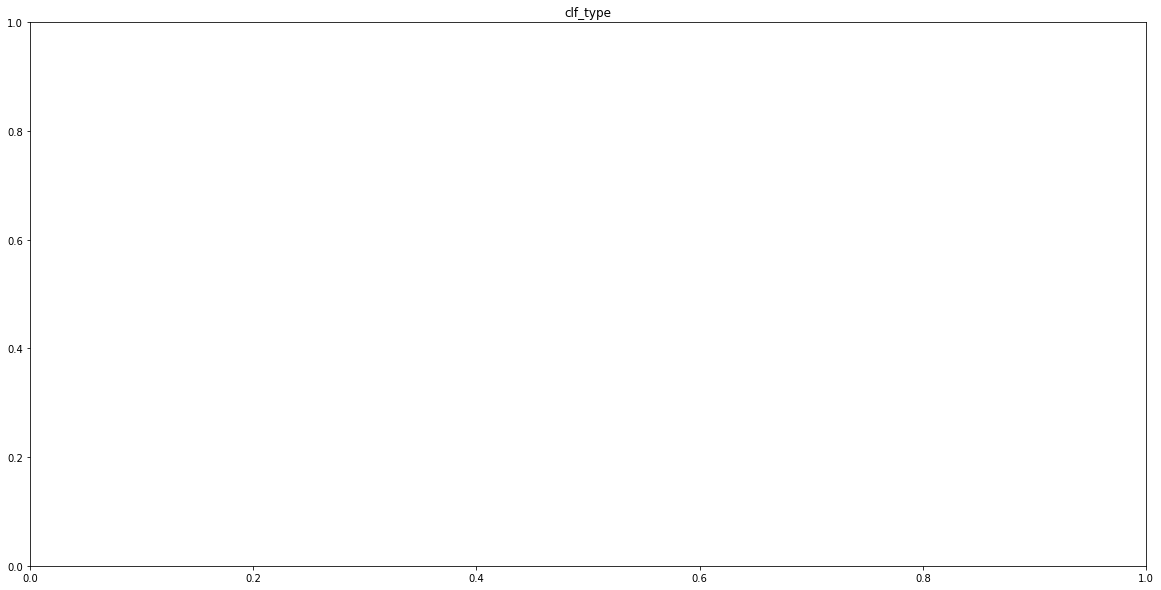

In [1091]:
plt.figure(figsize=(20,10))
main_plot_1D_attachment(trials=trials_clf3, attachment_name='clf_type')

Showing Histogram of 500 jobs


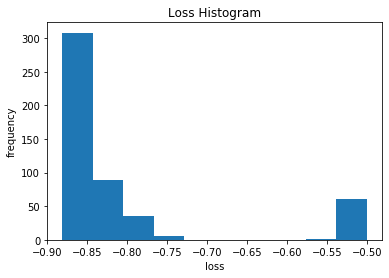

In [1120]:
main_plot_histogram(trials=trials_clf3)

avg best error: -0.8812348312656141


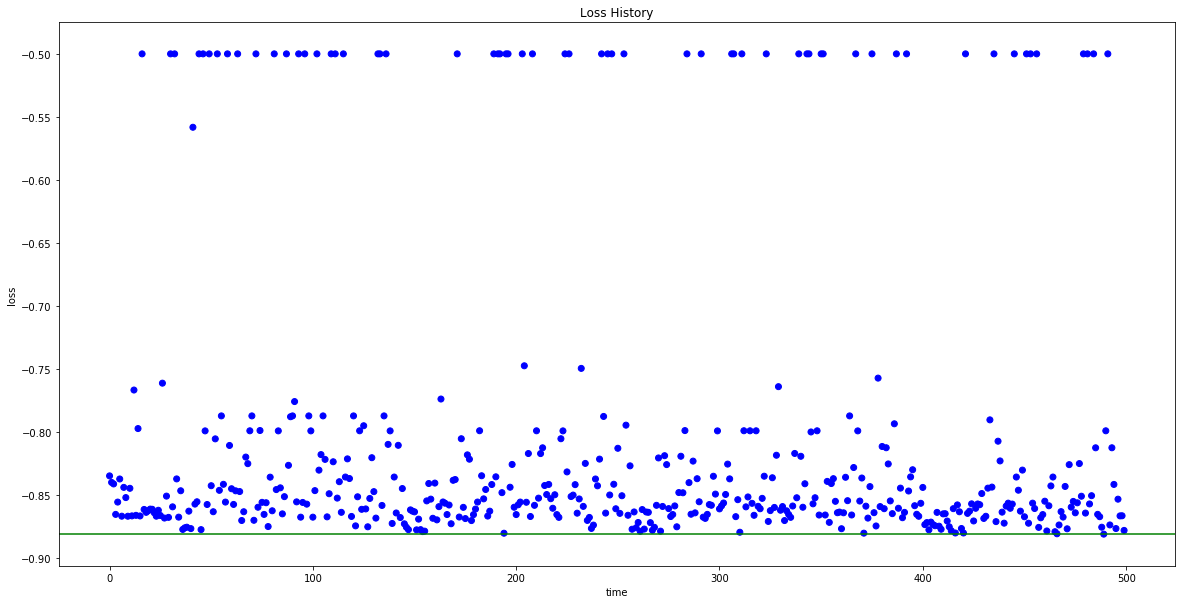

In [1121]:
plt.figure(figsize=(20,10))
main_plot_history(trials=trials_clf3)

finite loss range -0.8812348312656141 -0.5 -0.8730498770405577


C:\Users\T-Gamer\Anaconda3\envs\sklearn_novo\lib\site-packages\hyperopt\plotting.py:151: RuntimeWarning: divide by zero encountered in log
  y = np.log(vals[label])


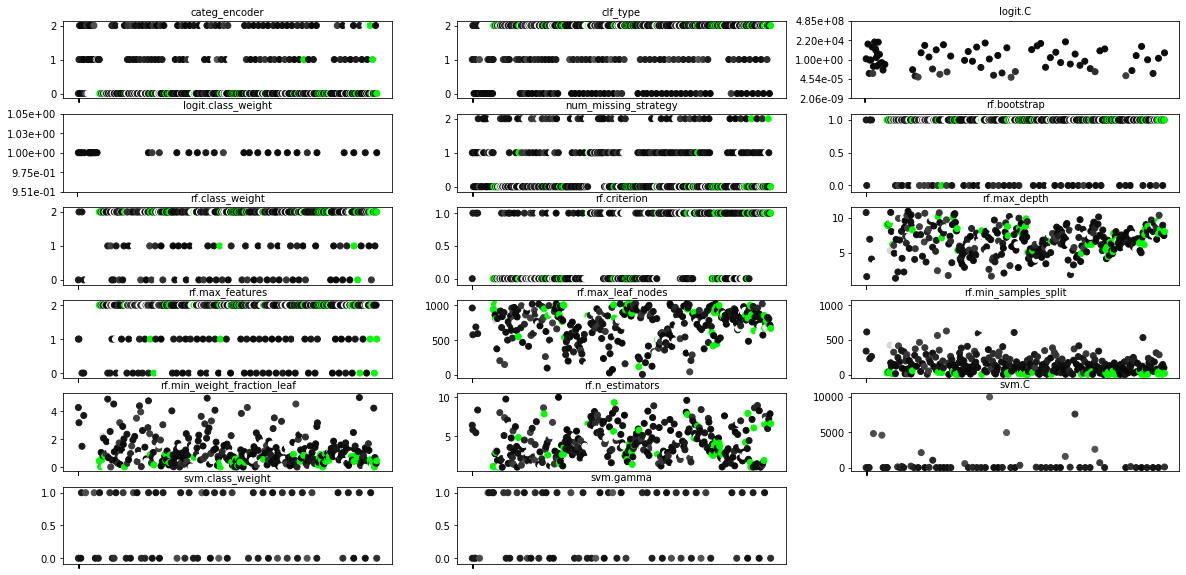

In [1122]:
# Here is a small example:
from hyperopt.plotting import main_plot_vars
from hyperopt import base

# setting up your search_space, objective_function, and trials goes here
# see the tutorials to know how
plt.figure(figsize=(20,10))
main_plot_vars(trials=trials_clf3, colorize_best=50, columns=3, arrange_by_loss=False)

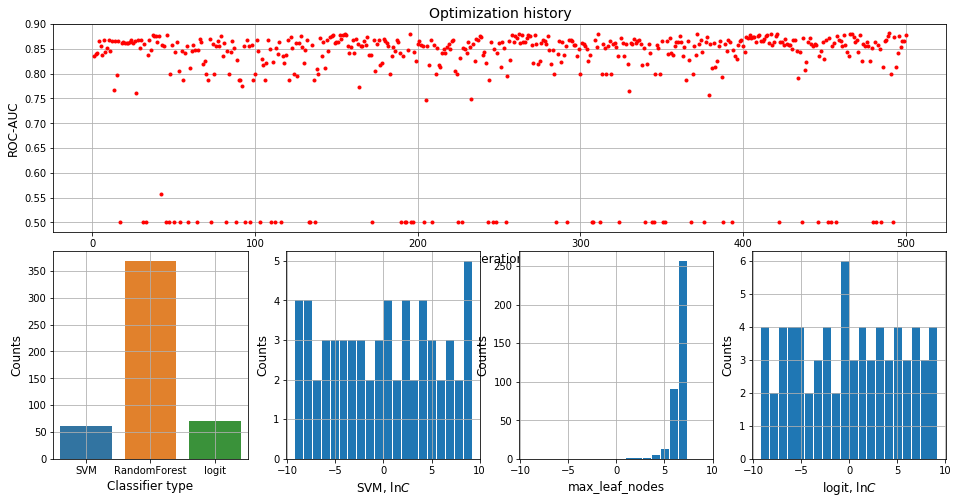

In [1123]:
fig0 = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(nrows=4, ncols=4)

# ================================
# Plotting optimization history

ax = fig0.add_subplot(gs[:2, :])
ax.plot(range(1, len(trials_clf3) + 1), [-x['result']['loss'] for x in trials_clf3], 
        color='red', marker='.', linewidth=0)

ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('ROC-AUC', fontsize=12)
ax.set_title('Optimization history', fontsize=14)

ax.grid(True)

# ================================
# Plotting sampled points

samples = [f_unpack_dict(f_wrap_space_eval(hp_space_clf3, x)) for x in trials_clf3.trials]

ax = fig0.add_subplot(gs[2:, 0])
sns.countplot(x=[x['type'] for x in samples], ax=ax)

ax.set_xlabel('Classifier type', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

ax.grid(True)

# ----------------

ax = fig0.add_subplot(gs[2:, 1:2])
ax.hist(np.log([x['C'] for x in samples if x['type'] == 'SVM']), bins=20, rwidth=0.9, 
        range=(-4*np.log(10), 4*np.log(10)))

ax.set_xlabel('SVM, $\ln C$', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

ax.grid(True)

# ----------------

ax = fig0.add_subplot(gs[2:, 3])
ax.hist(np.log([x['C'] for x in samples if x['type'] == 'logit']), bins=20, rwidth=0.9, 
        range=(-4*np.log(10), 4*np.log(10)))

ax.set_xlabel('logit, $\ln C$', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

ax.grid(True)

# ----------------

ax = fig0.add_subplot(gs[2:, 2:3])
ax.hist(np.log([x['max_leaf_nodes'] for x in samples if x['type'] == 'RandomForest']), bins=20, rwidth=0.9, 
        range=(-4*np.log(10), 4*np.log(10)))
ax.set_xlabel('max_leaf_nodes', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)

ax.grid(True)

# # ================================

# Modelo final pra mandar pro Kaggle

## Treinando modelo só na base de treino

In [1128]:
full_pipe.named_steps['features'].transformer_list

[('cat_flow', Pipeline(memory=None,
           steps=[('columnextractor',
                   ColumnExtractor(cols=['sex', 'embarked', 'title', 'name_aspas',
                                         'name_parenteses', 'pclass'],
                                   return_df=True)),
                  ('transformtodf',
                   TransformToDF(return_df=True,
                                 sklearn_transformer=SimpleImputer(add_indicator=False,
                                                                   copy=True,
                                                                   fill_value='CAT_MISSING',
                                                                   missing_values=nan,
                                                                   strategy='constant',
                                                                   verbose=0))),
                  ('woeencoder',
                   WOEEncoder(cols=['sex', 'embarked', 'title', 'name_aspas',
        

In [1124]:
full_pipe = f_clf3(space_eval(hp_space_clf3,best_clf3))
full_pipe.fit(df_train[num_cols+cat_cols], df_train['survived'])

Pipeline(memory=None,
         steps=[('features',
                 DFFeatureUnion(transformer_list=[('cat_flow',
                                                   Pipeline(memory=None,
                                                            steps=[('columnextractor',
                                                                    ColumnExtractor(cols=['sex',
                                                                                          'embarked',
                                                                                          'title',
                                                                                          'name_aspas',
                                                                                          'name_parenteses',
                                                                                          'pclass'],
                                                                                    return_df=True)),
            

In [1152]:
modelo3 = SaveModel(folder_to_save='./versions_submissions/versao3',
                  data_train=df_train,
                  data_val=df_val,
                  data_test=df_test,
                  model = full_pipe,
                str_readme='Random forest, fitado no train data. WOE encoder pra binários, mediana pra missing numérico',
                submission_file='submission_versao3.csv'
                   )

modelo3.save_model()
modelo3.commit_kaggle()

[WinError 183] Não é possível criar um arquivo já existente: './versions_submissions/versao3'
kaggle competitions submit -c titanic -f ./versions_submissions/versao3/submission_versao3.csv -m "Random forest, fitado no train data. WOE encoder pra binários, mediana pra missing numérico"


## Treinando na base toda (treino + validação)

In [1153]:
full_pipe = f_clf3(space_eval(hp_space_clf3,best_clf3))
full_pipe.fit(df_train_val[num_cols+cat_cols], df_train_val['survived'])

Pipeline(memory=None,
         steps=[('features',
                 DFFeatureUnion(transformer_list=[('cat_flow',
                                                   Pipeline(memory=None,
                                                            steps=[('columnextractor',
                                                                    ColumnExtractor(cols=['sex',
                                                                                          'embarked',
                                                                                          'title',
                                                                                          'name_aspas',
                                                                                          'name_parenteses',
                                                                                          'pclass'],
                                                                                    return_df=True)),
            

In [1155]:
modelo4 = SaveModel(folder_to_save='./versions_submissions/versao4',
                  data_train=df_train,
                  data_val=df_val,
                  data_test=df_test,
                  model = full_pipe,
                str_readme='Random forest, fitado no train + val data. WOE encoder pra binários, mediana pra missing numérico',
                submission_file='submission_versao3.csv'
                   )

modelo4.save_model()
modelo4.commit_kaggle()

[WinError 183] Não é possível criar um arquivo já existente: './versions_submissions/versao4'
